In [36]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
%matplotlib inline

In [2]:
cls = ['a','b','f']
# # translated_cls = [0,5,3]
# cl_a = os.listdir('fingerspelling5/dataset5/A/'+cls[0])
# cl_b = os.listdir('fingerspelling5/dataset5/A/'+cls[1])
# cl_f = os.listdir('fingerspelling5/dataset5/A/'+cls[2])
sessions = ['A','B','C','D','E']
data = []
for s in sessions:
    for each in range(len(cls)):
        for file in os.listdir('fingerspelling5/dataset5/'+s+'/'+cls[each]):
            if 'color' in file:
                tmp = [s+'/'+cls[each]+'/'+file, each]
                data.append(tmp)
df = pd.DataFrame(data, columns = ['path', 'label'])
df

,path,label
0,A/a/color_0_0130.png,0
1,A/a/color_0_0316.png,0
2,A/a/color_0_0174.png,0
3,A/a/color_0_0134.png,0
4,A/a/color_0_0400.png,0
...,...,...
8014,E/f/color_5_0374.png,2
8015,E/f/color_5_0454.png,2
8016,E/f/color_5_0470.png,2
8017,E/f/color_5_0085.png,2


In [3]:
labels = {
    0: 'zero',
    1: 'five',
    2: 'three'
}

In [4]:
def encode_label(label):
    target = torch.zeros(3)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [5]:
class SignLangDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['path'], row['label']
        img_fname = self.root_dir + "/" + img_id
        img = Image.open(img_fname)
        size = 130,130
        img = img.resize((size))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = SignLangDataset(df,'fingerspelling5/dataset5/', transform=transform)

(104, 117)
(130, 130)


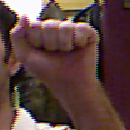

In [9]:
# img = Image.open('fingerspelling5/dataset5/A/a/color_0_0316.png')
img = Image.open('fingerspelling5/dataset5/A/a/color_0_0016.png')
type(img)
print(img.size)
size = 130,130
newimg=img.resize((size))
print(newimg.size)
newimg

In [10]:
len(dataset)

8019

In [11]:
dataset[3][0].size()

torch.Size([3, 130, 130])

In [12]:
def show_sample(img, target, invert=True):
    plt.imshow(img.permute(1, 2, 0))
#     plt.imshow(img)
    print('Labels:', decode_target(target, text_labels=True))
    

Labels: zero(0)


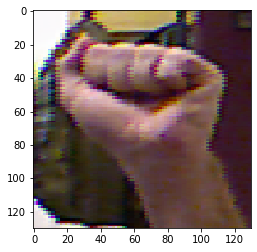

In [15]:
show_sample(*dataset[60], invert=False)

In [16]:
torch.manual_seed(5)

In [17]:
val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [18]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(6416, 1603)

In [19]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [20]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [21]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [22]:
class ProteinCnnModel2(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 3)
    
    def forward(self, xb):
#         return torch.sigmoid(self.network(xb))
        return F.softmax(self.network(xb), dim=1)

In [23]:
model = ProteinCnnModel2()
model

# model.load_state_dict(torch.load('resnet_signlang_andrew.pth'))

ProteinCnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

cuda


In [26]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([64, 3, 130, 130])
out.shape: torch.Size([64, 3])
out[0]: tensor([0.4753, 0.2211, 0.3036], device='cuda:0', grad_fn=<SelectBackward>)


In [27]:
from tqdm.notebook import tqdm

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [47]:
model = to_device(ProteinCnnModel2(), device)

In [29]:
evaluate(model, val_dl)

{'val_loss': 0.6743448972702026, 'val_score': 0.12801377475261688}

In [30]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 1e-3

In [31]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.0314, val_loss: 0.0001, val_score: 1.0000



Epoch [1], train_loss: 0.0099, val_loss: 0.0002, val_score: 1.0000



Epoch [2], train_loss: 0.0002, val_loss: 0.0000, val_score: 1.0000



Epoch [3], train_loss: 0.0000, val_loss: 0.0000, val_score: 1.0000



Epoch [4], train_loss: 0.0000, val_loss: 0.0000, val_score: 1.0000


In [32]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [33]:
img, target = dataset[0]
img.shape

torch.Size([3, 130, 130])

Prediction:  tensor([2.1275e-07, 2.3494e-06, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: three(2)


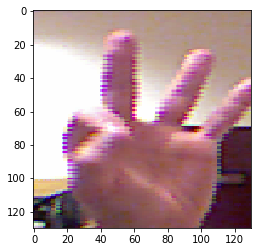

In [42]:
predict_single(dataset[6000][0])

Prediction:  tensor([0.0225, 0.0606, 0.9169], device='cuda:0', grad_fn=<SelectBackward>)
Labels: three(2)


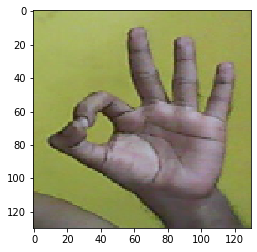

In [46]:
# sm_img = 'five.jpg'
# sm_img = 'threeyo.jpg'
# sm_img = 'zero.jpg'
sm_img = 'crped.jpg'
img = Image.open(sm_img).resize((130,130))
img = ToTensor()(img)
predict_single(img)

In [41]:
torch.save(model.state_dict(), 'resnet_signlang_andrew_v3.pth')

In [1]:
import jovian

In [2]:
jovian.commit(project='Course-Project-Exploration')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "andrew2moses/Course-Project-Exploration"
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/andrew2moses/course-project-exploration


'https://jovian.ml/andrew2moses/course-project-exploration'